In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
# import xgboost as xgb
# from xgboost import DMatrix
from sklearn.metrics import ndcg_score

In [5]:
df = pd.read_csv('all_data.csv')
df.head()

,race_id,date,quarter,year,month,month_cos,month_sin,place,track,length,...,length_top3,direction_count,direction_win_score,direction_top3,win_score,jockey_id,jockey_weight,jockey_age,jockey_win_rate,jockey_win_count
0,202002020410,2020-07-12,3,2020,7,-0.866025,-0.5,1,0,2600,...,0,0,0.0000,0,1.000,1015,50,42,0.1850,2
1,202002020410,2020-07-12,3,2020,7,-0.866025,-0.5,1,0,2600,...,1,1,0.5000,1,0.500,1091,47,34,0.1692,0
2,202002020410,2020-07-12,3,2020,7,-0.866025,-0.5,1,0,2600,...,0,0,0.0000,0,0.333,5203,50,46,0.2927,0
3,202002020410,2020-07-12,3,2020,7,-0.866025,-0.5,1,0,2600,...,0,0,0.0000,0,0.250,1032,45,40,0.2289,0
4,202002020410,2020-07-12,3,2020,7,-0.866025,-0.5,1,0,2600,...,1,2,0.6665,2,0.200,1127,47,29,0.2103,1


In [16]:
def conv_condition(val):
    if val == 0:
        return val
    return 1
df['condition_2'] = pd.Series(np.vectorize(conv_condition)(df['condition']), index=df.index)

In [17]:
# attributions * race info
len_items = sorted(df['length'].unique().tolist())
age_items = sorted(df['age'].unique().tolist())

def conv_attr(val):
    return val * 2 - 1

def conv_course(track, attr):
    return (track-1) * conv_attr(attr)

def conv_length(len, attr):
    return np.cos(np.pi * len / len_items[-1]) * conv_attr(attr)

def conv_growth(age, attr):
    return np.cos(np.pi * age / age_items[-1] * conv_attr(attr))

def conv_condition(cond, attr):
    if cond == 0:
        return 0
    if cond == 1:
        return conv_attr(attr) / 2
    return conv_attr(attr)

df['attr_course*race'] = pd.Series(np.vectorize(conv_course)(df['track'], df['attr_course']), index=df.index)
df['attr_length*race'] = pd.Series(np.vectorize(conv_length)(df['length'], df['attr_length']), index=df.index)
df['attr_leg*race'] = pd.Series(np.vectorize(conv_attr)(df['attr_leg']), index=df.index)
df['attr_growth*race'] = pd.Series(np.vectorize(conv_growth)(df['age'], df['attr_growth']), index=df.index)
df['attr_condition*race'] = pd.Series(np.vectorize(conv_condition)(df['condition_2'], df['attr_condition']), index=df.index)

df['weight_par_horse'] = df['jockey_weight'] / df['weight']
df['weight_par_horse'] = df['weight_par_horse'].replace(float('inf'), 0)

In [18]:
def conv_res_rate(target, other_1, other_2, other_3):
    if (target + other_1 + other_2 + other_3) == 0:
        return 0.0
    return target / (target + other_1 + other_2 + other_3)

df['f_res_1st'] = pd.Series(np.vectorize(conv_res_rate)(df['f_res_1st'], df['f_res_2nd'], df['f_res_3rd'], df['f_res_lose']), index=df.index).astype(np.float32)
df['f_res_2nd'] = pd.Series(np.vectorize(conv_res_rate)(df['f_res_2nd'], df['f_res_1st'], df['f_res_3rd'], df['f_res_lose']), index=df.index).astype(np.float32)
df['f_res_3rd'] = pd.Series(np.vectorize(conv_res_rate)(df['f_res_3rd'], df['f_res_1st'], df['f_res_2nd'], df['f_res_lose']), index=df.index).astype(np.float32)
df['f_res_lose'] = pd.Series(np.vectorize(conv_res_rate)(df['f_res_lose'], df['f_res_1st'], df['f_res_2nd'], df['f_res_3rd']), index=df.index).astype(np.float32)
df['mf_res_1st'] = pd.Series(np.vectorize(conv_res_rate)(df['mf_res_1st'], df['mf_res_2nd'], df['mf_res_3rd'], df['mf_res_lose']), index=df.index).astype(np.float32)
df['mf_res_2nd'] = pd.Series(np.vectorize(conv_res_rate)(df['mf_res_2nd'], df['mf_res_1st'], df['mf_res_3rd'], df['mf_res_lose']), index=df.index).astype(np.float32)
df['mf_res_3rd'] = pd.Series(np.vectorize(conv_res_rate)(df['mf_res_3rd'], df['mf_res_1st'], df['mf_res_2nd'], df['mf_res_lose']), index=df.index).astype(np.float32)
df['mf_res_lose'] = pd.Series(np.vectorize(conv_res_rate)(df['mf_res_lose'], df['mf_res_1st'], df['mf_res_2nd'], df['mf_res_3rd']), index=df.index).astype(np.float32)

In [21]:
df_train = df[df['date'] < '2019-07-01']
df_test = df[df['date'] >= '2019-07-01']

print(df_train.shape, df_test.shape)

(35806, 64) (8370, 64)


In [22]:
train_query = df_train.groupby('race_id')['date'].count().tolist()
test_query = df_test.groupby('race_id')['date'].count().tolist()

In [30]:
cols = ['place', 'track', 'length', 'direction', 'weather', 'condition', 'horse_num_2', 'jockey_id',
        # 'popularity', 
        'sex', 'age', 'trainer', 
        # 'attr_course*race', 'attr_length*race', 'attr_leg*race', 'attr_growth*race', 'attr_condition*race',
        'f_res_1st', 'f_res_2nd', 'f_res_3rd', 'f_res_lose',
        'mf_res_1st', 'mf_res_2nd', 'mf_res_3rd', 'mf_res_lose',
        'weight', 'weight_par_horse', 'jockey_weight', 'jockey_age', 'total_count', 'total_score', 'total_top3',
        'place_count', 'place_win_score', 'place_top3', 'length_count', 'length_win_score', 'length_top3',
        'direction_count', 'direction_win_score', 'direction_top3',
        # 'quarter', 'year', 'month',
        'month_cos', 'month_sin', 'weather*condition']

In [31]:
# LightGBM

params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'lambdarank_truncation_level': 10,
    'ndcg_eval_at': [5, 10, 20],
    'n_estimators': 10000,
    'boosting_type': 'gbdt',
    'random_state': 0,
}


lgtrain = lgb.Dataset(df_train[cols], df_train['rank'], group=train_query)
lgvalid = lgb.Dataset(df_test[cols], df_test['rank'], group=test_query)
lgb_clf = lgb.train(
    params,
    lgtrain,
    valid_sets=[lgvalid],
    early_stopping_rounds=2,
    verbose_eval=5
)

C:\Users\ayane hara\anaconda3\envs\new\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 2 rounds
[5]	valid_0's ndcg@5: 0.418539	valid_0's ndcg@10: 0.537633	valid_0's ndcg@20: 0.602886
Early stopping, best iteration is:
[5]	valid_0's ndcg@5: 0.418539	valid_0's ndcg@10: 0.537633	valid_0's ndcg@20: 0.602886


In [32]:
pred = lgb_clf.predict(df_test[cols], num_iteration=lgb_clf.best_iteration)
pred_df = pd.DataFrame({
    "query_id": np.repeat(np.arange(len(test_query)), test_query),
    "pred": pred,
    "true": df_test['rank']
})

def get_pred(row):
    temp = pred_df[pred_df['query_id'] == row['query_id']]
    preds = sorted(temp['pred'].values.tolist(), reverse=True)
    return preds.index(row['pred']) + 1
pred_df['pred_rank'] = pred_df.apply(get_pred, axis=1)

pred_df[pred_df['query_id'] == 0]

,query_id,pred,true,pred_rank
0,0,0.121944,1,1
1,0,-0.191095,2,8
2,0,-0.082063,3,5
3,0,0.056518,4,2
4,0,-0.191095,5,8
5,0,-0.159413,6,7
6,0,0.034922,7,3
7,0,-0.091653,8,6
8,0,-0.033026,9,4
9,0,-0.243289,10,10


In [33]:
print(pred_df.groupby("query_id").apply(lambda d: ndcg_score([d["true"]], [d["pred"]], k=10)).mean())

0.7879898461246001


In [34]:
pred = lgb_clf.predict(df_test[cols], num_iteration=lgb_clf.best_iteration)
pred_df_lgb = pd.DataFrame({
    "query_id": np.repeat(np.arange(len(test_query)), test_query),
    "pred": pred,
    "true": df_test['rank']
})

def get_pred(row):
    temp = pred_df_lgb[pred_df_lgb['query_id'] == row['query_id']]
    preds = sorted(temp['pred'].values.tolist(), reverse=True)
    return preds.index(row['pred']) + 1
pred_df_lgb['pred_rank'] = pred_df_lgb.apply(get_pred, axis=1)

pred_df_lgb.head(21)

,query_id,pred,true,pred_rank
0,0,0.121944,1,1
1,0,-0.191095,2,8
2,0,-0.082063,3,5
3,0,0.056518,4,2
4,0,-0.191095,5,8
5,0,-0.159413,6,7
6,0,0.034922,7,3
7,0,-0.091653,8,6
8,0,-0.033026,9,4
9,0,-0.243289,10,10


In [36]:
print(pred_df_lgb.groupby("query_id").apply(lambda d: ndcg_score([d["true"]], [d["pred"]], k=10)).mean())

0.7879898461246001


,feature,importance
24,total_score,0.093333
7,jockey_id,0.086667
9,age,0.086667
11,f_res_1st,0.060000
6,horse_num_2,0.053333
10,trainer,0.053333
30,length_win_score,0.046667
23,total_count,0.040000
33,direction_win_score,0.040000
21,jockey_weight,0.040000


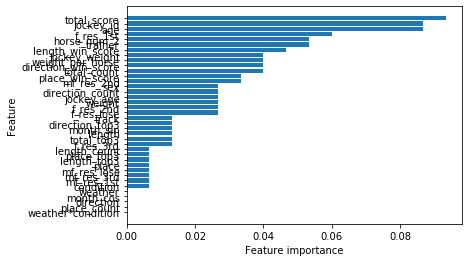

In [37]:
def plot_feature_importance(df): 
    n_features = len(df) # 特徴量数(説明変数の個数) 
    df_plot = df.sort_values('importance') # df_importanceをプロット用に特徴量重要度を昇順ソート 
    f_imoprtance_plot = df_plot['importance'].values # 特徴量重要度の取得 
    plt.barh(range(n_features), f_imoprtance_plot, align='center') 
    cols_plot = df_plot['feature'].values # 特徴量の取得 
    plt.yticks(np.arange(n_features), cols_plot)  # x軸,y軸の値の設定
    plt.xlabel('Feature importance') # x軸のタイトル
    plt.ylabel('Feature') # y軸のタイトル

f_importance = np.array(lgb_clf.feature_importance()) # 特徴量重要度の算出
f_importance = f_importance / np.sum(f_importance) # 正規化(必要ない場合はコメントアウト)
df_importance = pd.DataFrame({'feature':cols, 'importance':f_importance})
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

plot_feature_importance(df_importance)

In [ ]:
xgb_params =  {
    'objective': 'rank:pairwise',
    'eta': 0.1,
    'gamma': 0.0001,
    'min_child_weight': 0.1,
    'max_depth': 6
}
xgtrain = DMatrix(df_train[cols], df_train['rank'])
xgtrain.set_group(train_query)
xgvalid = DMatrix(df_test[cols], df_test['rank'])
xgvalid.set_group(test_query)

xgb_clf = xgb.train(
    xgb_params,
    xgtrain,
    num_boost_round=10,
    evals=[(xgvalid, 'validation')]
)

[0]	validation-map:1
[1]	validation-map:1
[2]	validation-map:1
[3]	validation-map:1
[4]	validation-map:1
[5]	validation-map:1
[6]	validation-map:1
[7]	validation-map:1
[8]	validation-map:1
[9]	validation-map:1


In [ ]:
pred = xgb_clf.predict(DMatrix(df_test[cols]))
pred_df_xgb = pd.DataFrame({
    "query_id": np.repeat(np.arange(len(test_query)), test_query),
    "pred": pred,
    "true": df_test['rank']
})

def get_pred(row):
    temp = pred_df_xgb[pred_df_xgb['query_id'] == row['query_id']]
    preds = sorted(temp['pred'].values.tolist(), reverse=True)
    return preds.index(row['pred']) + 1
pred_df_xgb['pred_rank'] = pred_df_xgb.apply(get_pred, axis=1)

pred_df_xgb[pred_df_xgb['query_id'] == 0]

,query_id,pred,true,pred_rank
0,0,0.752527,1,2
1,0,0.304796,2,7
2,0,0.357920,3,6
3,0,0.225591,4,9
4,0,0.268203,5,8
5,0,0.517370,6,4
6,0,0.506253,7,5
7,0,0.765919,8,1
8,0,0.591697,9,3
9,0,-0.024327,10,10


In [ ]:
print(pred_df.groupby("query_id").apply(lambda d: ndcg_score([d["true"]], [d["pred"]], k=10)).mean())

0.8559108205633071
